# Environmental Indicators for Different Sites

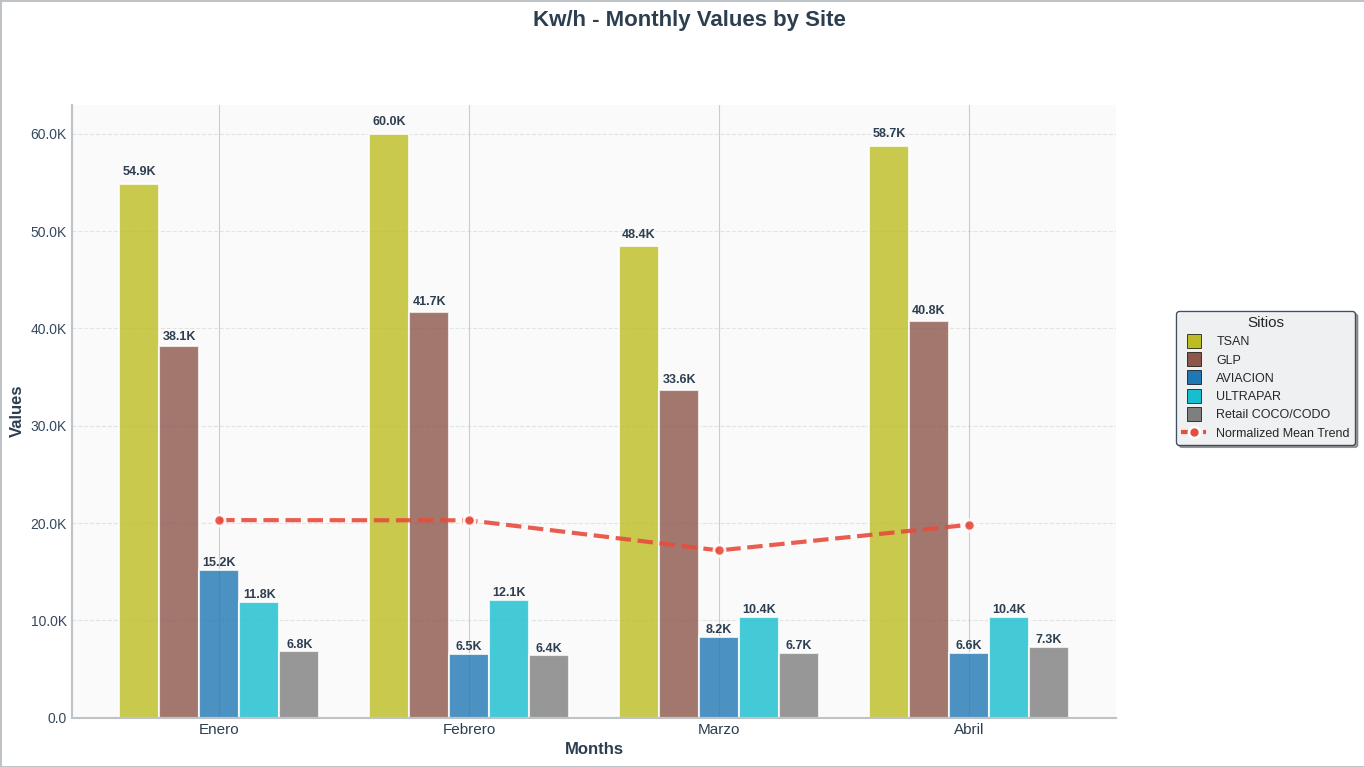

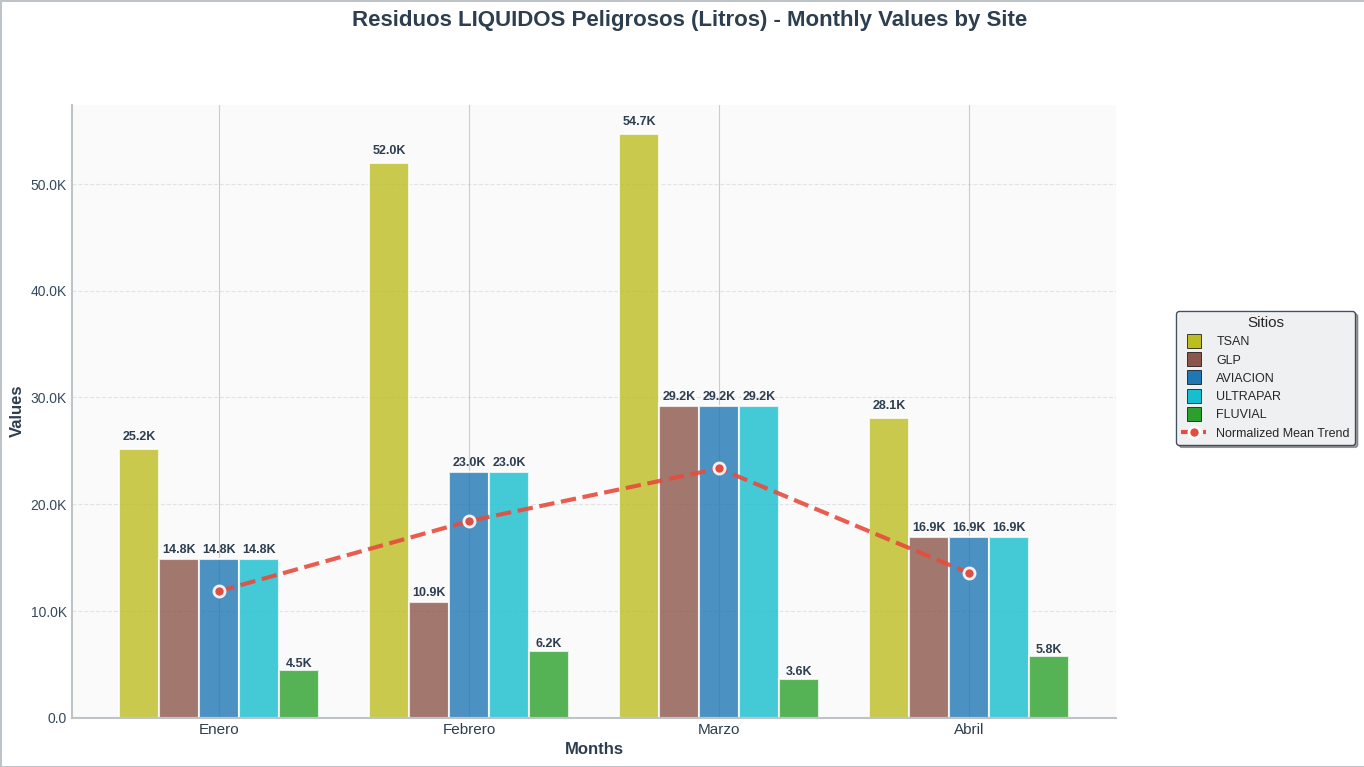

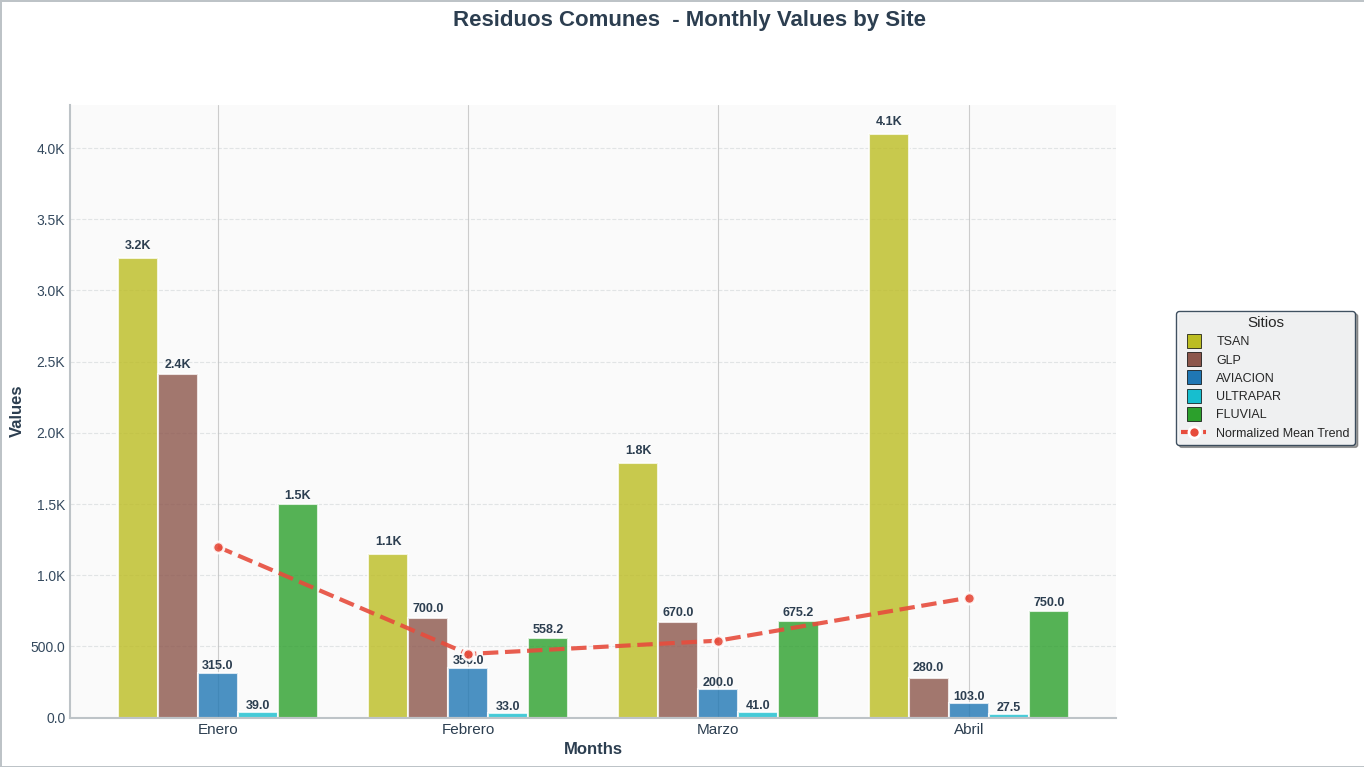

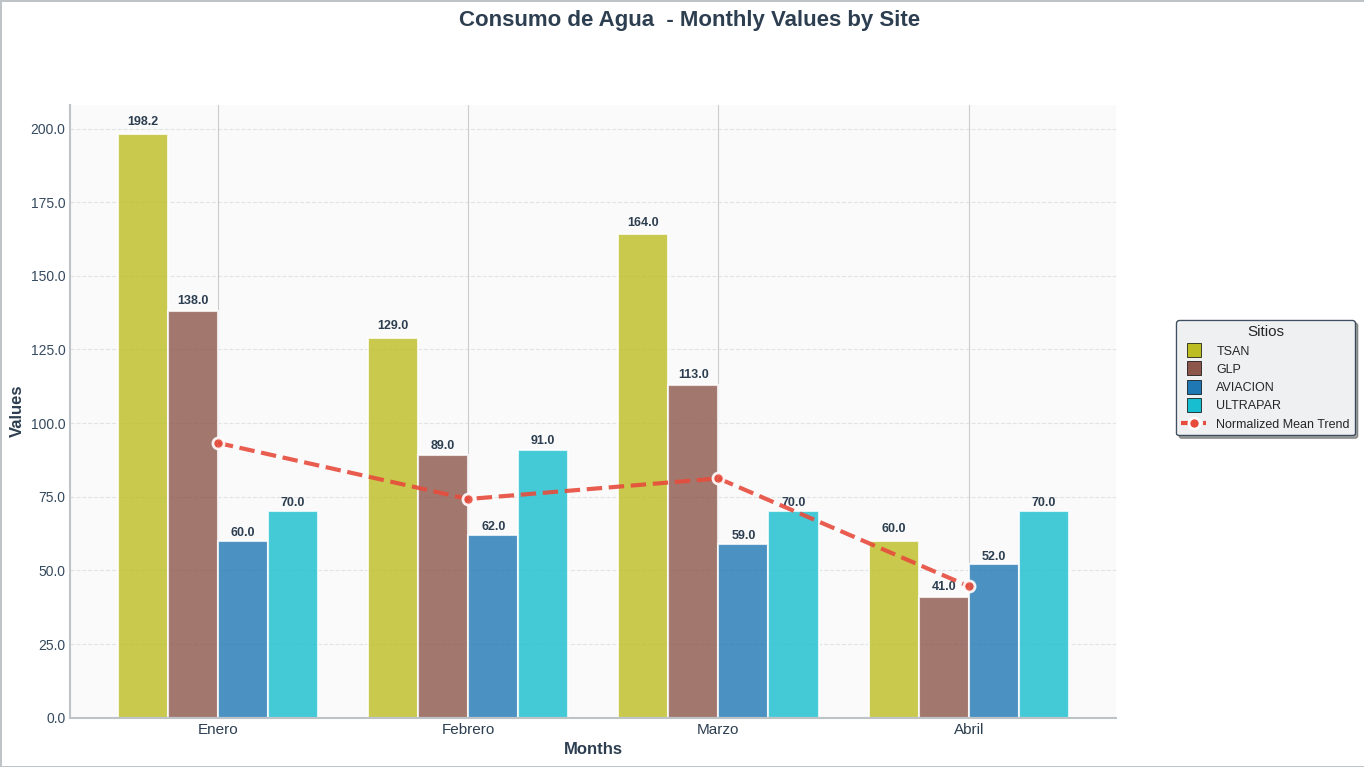

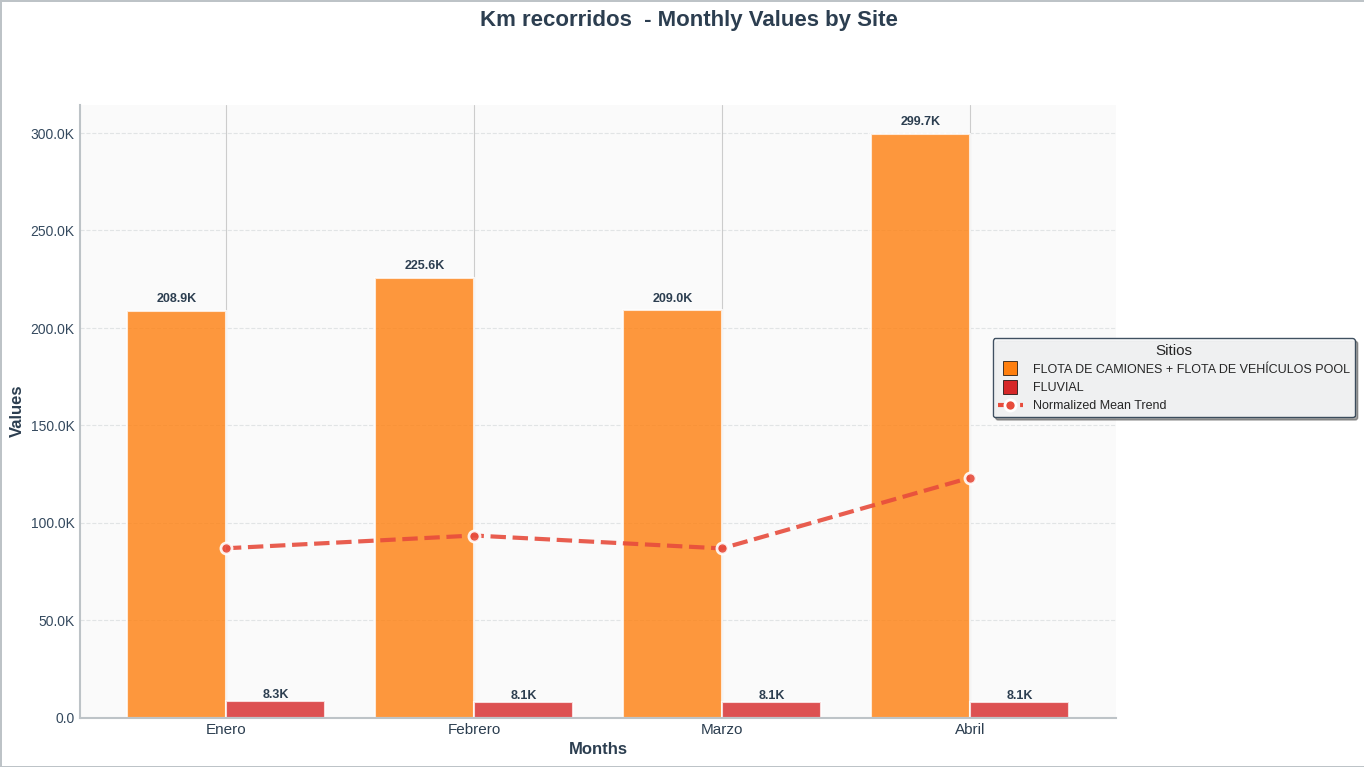

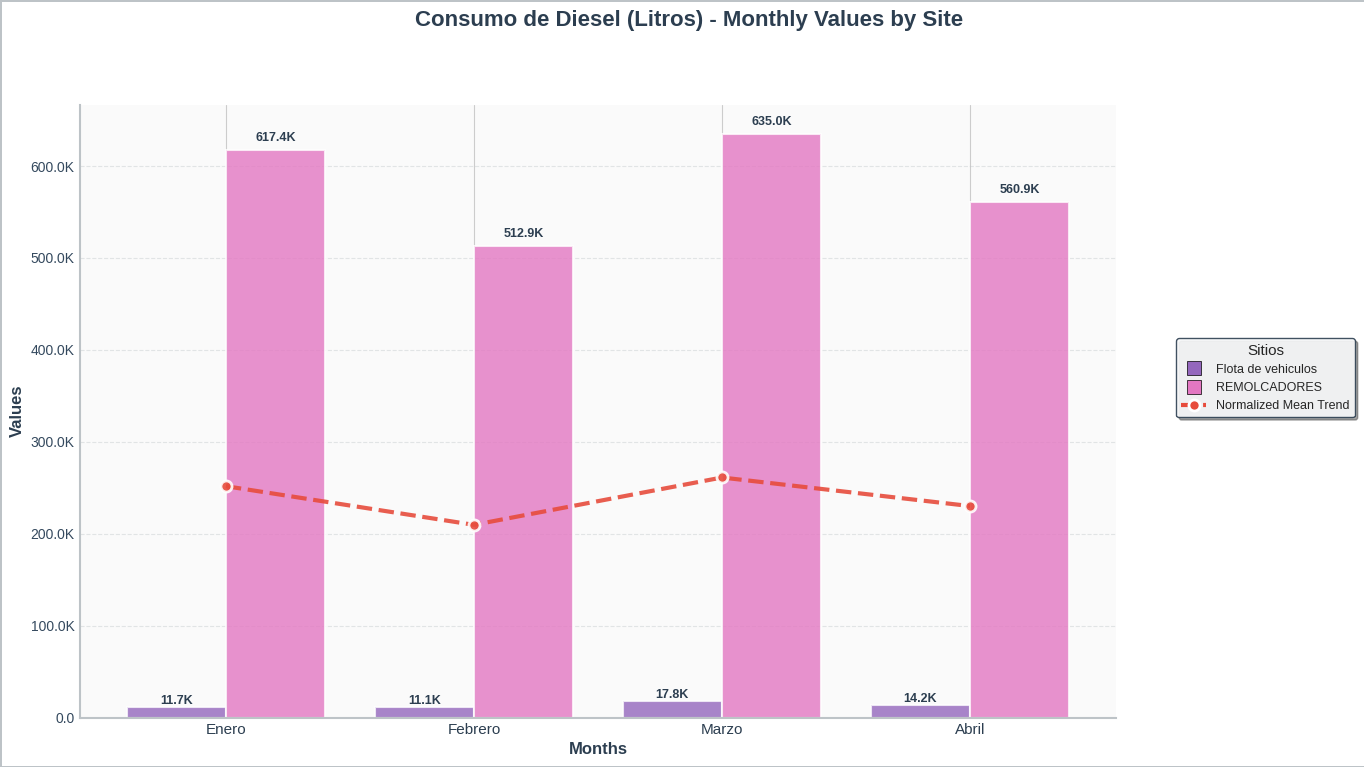

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

# Import project utilities
import sys

sys.path.append("../../")
from src.utils.data_processing import *  # noqa: F403
from src.utils.visualization import *  # noqa: F403

# Visualization settings
plt.style.use("seaborn-v0_8-whitegrid")
%matplotlib inline
sns.set_palette("viridis")
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option("display.max_columns", None)

# For reproducibility
np.random.seed(42)

# Configuration
INPUT_DIR = "../../data/processed/sites/df1/"

# Global visualization settings
used_colors = set()
site_color_mapping = {}
available_css4_colors = list(mcolors.CSS4_COLORS.keys())

# Load all section data using a for loop
section_data = {}
for i in range(0, 7):
    section_name = f"section_{i}"
    file_path = os.path.join(INPUT_DIR, f"{section_name}.csv")
    section_data[section_name] = pd.read_csv(file_path)


def create_environmental_indicators_monthly_charts() -> None:
    """Create monthly bar charts for environmental indicators by site."""
    plt.style.use("seaborn-v0_8-whitegrid")

    # Track all sites for consistent color mapping
    all_sites = set()

    # Sections to plot
    sections_to_plot = [
        "section_0",
        "section_2",
        "section_3",
        "section_4",
        "section_5",
        "section_6",
    ]

    # First pass: collect all unique sites
    for section_name in sections_to_plot:
        df = section_data[section_name]
        month_cols = ["Enero", "Febrero", "Marzo", "Abril"]
        plot_data = df[df[month_cols].notna().any(axis=1)].copy()
        if len(plot_data) > 0:
            site_names = plot_data["Stios"].tolist()
            all_sites.update(site_names)

    # Create consistent color mapping for all sites
    sorted_sites = sorted(all_sites)
    color_cycle = plt.cm.tab10(np.linspace(0, 1, len(sorted_sites)))
    global_site_colors = {
        site: color_cycle[i] for i, site in enumerate(sorted_sites)
    }

    # Create individual monthly charts for each section
    for section_name in sections_to_plot:
        _create_monthly_section_chart(
            section_name, global_site_colors, sorted_sites
        )


def _create_monthly_section_chart(
    section_name: str, global_site_colors: dict, sorted_sites: list
) -> None:
    """Create a monthly bar chart for a single section."""
    df = section_data[section_name]
    month_cols = ["Enero", "Febrero", "Marzo", "Abril"]

    # Check if there's data to plot
    plot_data = df[df[month_cols].notna().any(axis=1)].copy()

    if len(plot_data) == 0:
        print(f"No data to plot for {section_name}")
        return

    # Create individual figure with adjusted layout
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    fig.patch.set_facecolor("white")

    # Get title from first Indicador value
    title = _get_section_title(df)
    fig.suptitle(
        f"{title} - Monthly Values by Site",
        fontsize=16,
        fontweight="bold",
        y=0.96,
        color="#2C3E50",
    )

    # Prepare data for plotting
    sites_with_data = []
    monthly_data = {}

    for _, row in plot_data.iterrows():
        site = row["Stios"]
        site_monthly_values = {}

        for month in month_cols:
            if pd.notna(row[month]):
                site_monthly_values[month] = row[month]

        if site_monthly_values:  # Only include sites with at least one value
            sites_with_data.append(site)
            monthly_data[site] = site_monthly_values

    if not sites_with_data:
        print(f"No numeric data to plot for {section_name}")
        return

    # Calculate normalized mean trend line data
    all_values = []
    monthly_means = []

    for month in month_cols:
        month_values = []
        for site in sites_with_data:
            if month in monthly_data[site]:
                month_values.append(monthly_data[site][month])

        if month_values:
            monthly_means.append(np.mean(month_values))
            all_values.extend(month_values)
        else:
            monthly_means.append(0)

    # Normalize the mean values to create trend line
    if all_values and max(all_values) > 0:
        max_value = max(all_values)
        normalized_means = [
            mean / max_value * max_value * 0.8 for mean in monthly_means
        ]
    else:
        normalized_means = monthly_means

    # Create grouped bar chart
    x_positions = np.arange(len(month_cols))
    bar_width = 0.8 / len(sites_with_data)

    for i, site in enumerate(sites_with_data):
        site_values = []

        for month in month_cols:
            if month in monthly_data[site]:
                site_values.append(monthly_data[site][month])
            else:
                site_values.append(0)  # Fill missing values with 0

        positions = x_positions + i * bar_width
        color = global_site_colors.get(site, "#3498DB")

        bars = ax.bar(
            positions,
            site_values,
            bar_width,
            label=site,
            color=color,
            alpha=0.8,
            edgecolor="white",
            linewidth=1.5,
        )

        # Add value labels on top of bars
        for bar, value in zip(bars, site_values):
            if value > 0:  # Only show labels for non-zero values
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height + max(site_values) * 0.01,
                    _format_value(value),
                    ha="center",
                    va="bottom",
                    fontsize=9,
                    fontweight="bold",
                    color="#2C3E50",
                )

    # Add normalized dashed mean trend line
    if normalized_means and any(mean > 0 for mean in normalized_means):
        trend_x = x_positions + bar_width * (len(sites_with_data) - 1) / 2
        ax.plot(
            trend_x,
            normalized_means,
            color="#E74C3C",
            linestyle="--",
            linewidth=3,
            marker="o",
            markersize=8,
            markerfacecolor="#E74C3C",
            markeredgecolor="white",
            markeredgewidth=2,
            label="Normalized Mean Trend",
            alpha=0.9,
            zorder=10,
        )

    # Style the chart
    _style_monthly_chart(
        ax, month_cols, x_positions, bar_width, len(sites_with_data)
    )

    # Add legend for this chart
    if sites_with_data:
        _add_chart_legend(fig, sites_with_data, global_site_colors)

    # Final layout adjustments - reduced padding and better space utilization
    plt.tight_layout(pad=1.5, rect=[0, 0, 0.82, 0.92])
    fig.patch.set_edgecolor("#BDC3C7")
    fig.patch.set_linewidth(2)
    plt.show()


def _get_section_title(df: pd.DataFrame) -> str:
    """Get appropriate title for section chart."""
    if "Indicador" in df.columns:
        indicador_values = df["Indicador"].dropna()
        if len(indicador_values) > 0:
            return indicador_values.iloc[0]
    return "Unknown"


def _style_monthly_chart(
    ax,
    month_cols: list,
    x_positions: np.ndarray,
    bar_width: float,
    num_sites: int,
) -> None:
    """Apply consistent styling to monthly chart."""
    # Set labels
    ax.set_xlabel("Months", fontsize=12, color="#2C3E50", fontweight="bold")
    ax.set_ylabel("Values", fontsize=12, color="#2C3E50", fontweight="bold")

    # Set x-axis ticks and labels
    ax.set_xticks(x_positions + bar_width * (num_sites - 1) / 2)
    ax.set_xticklabels(month_cols, fontsize=11, color="#2C3E50")

    # Style ticks
    ax.tick_params(axis="x", labelsize=11, colors="#2C3E50")
    ax.tick_params(axis="y", labelsize=10, colors="#34495E")

    # Style grid and spines
    ax.grid(
        True,
        alpha=0.4,
        linestyle="--",
        linewidth=0.8,
        color="#BDC3C7",
        axis="y",
    )
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("#BDC3C7")
    ax.spines["bottom"].set_color("#BDC3C7")
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)

    # Format y-axis with improved formatting
    def format_thousands(x, pos):
        if x >= 1000000:
            return f"{x / 1000000:.1f}M"
        elif x >= 1000:
            return f"{x / 1000:.1f}K"
        else:
            return f"{x:.1f}"

    ax.yaxis.set_major_formatter(FuncFormatter(format_thousands))
    ax.set_facecolor("#FAFAFA")


def _format_value(value: float) -> str:
    """Format value for display on chart."""
    if value >= 1000000:
        return f"{value / 1000000:.1f}M"
    elif value >= 1000:
        return f"{value / 1000:.1f}K"
    else:
        return f"{value:.1f}"


def _add_chart_legend(fig, site_names: list, global_site_colors: dict) -> None:
    """Add a legend for the current chart with matching colors."""
    handles = []
    for site in site_names:
        handles.append(
            plt.Line2D(
                [0],
                [0],
                marker="s",
                color="w",
                markerfacecolor=global_site_colors[site],
                label=site,
                markersize=10,
                linestyle="",
                markeredgecolor="black",
                markeredgewidth=0.5,
            )
        )

    # Add trend line to legend
    handles.append(
        plt.Line2D(
            [0],
            [0],
            color="#E74C3C",
            linestyle="--",
            linewidth=3,
            marker="o",
            markersize=8,
            markerfacecolor="#E74C3C",
            markeredgecolor="white",
            markeredgewidth=2,
            label="Normalized Mean Trend",
        )
    )

    # Add legend to the figure with adjusted positioning
    fig.legend(
        handles,
        site_names + ["Normalized Mean Trend"],
        loc="center right",
        bbox_to_anchor=(0.98, 0.5),
        title="Sitios",
        title_fontsize=11,
        fontsize=9,
        frameon=True,
        fancybox=True,
        shadow=True,
        framealpha=0.9,
        edgecolor="#2C3E50",
        facecolor="#F8F9FA",
    )


# Create monthly bar chart visualizations
create_environmental_indicators_monthly_charts()


In [9]:
from IPython.display import display, HTML


def create_delta_variation_table():
    """Create a table showing delta variations for each site across months and criteria."""

    # Sections to analyze
    sections_to_analyze = [
        "section_0",
        "section_2",
        "section_3",
        "section_4",
        "section_5",
        "section_6",
    ]

    # Collect all data
    all_delta_data = []
    month_cols = ["Enero", "Febrero", "Marzo", "Abril"]

    for section_name in sections_to_analyze:
        df = section_data[section_name]

        # Get section title
        if "Indicador" in df.columns:
            indicador_values = df["Indicador"].dropna()
            criteria = (
                indicador_values.iloc[0]
                if len(indicador_values) > 0
                else section_name
            )
        else:
            criteria = section_name

        # Process each site in this section
        for _, row in df.iterrows():
            if pd.isna(row["Stios"]):
                continue

            site = row["Stios"]
            monthly_values = []

            # Extract monthly values
            for month in month_cols:
                if month in row and pd.notna(row[month]):
                    monthly_values.append(float(row[month]))
                else:
                    monthly_values.append(np.nan)

            # Calculate deltas only if we have at least 2 values
            valid_values = [v for v in monthly_values if not pd.isna(v)]
            if len(valid_values) >= 2:
                deltas = []

                # Calculate month-to-month deltas
                for i in range(1, len(monthly_values)):
                    if not pd.isna(monthly_values[i - 1]) and not pd.isna(
                        monthly_values[i]
                    ):
                        delta = monthly_values[i] - monthly_values[i - 1]
                        delta_pct = (
                            (delta / monthly_values[i - 1] * 100)
                            if monthly_values[i - 1] != 0
                            else 0
                        )
                        deltas.append(delta_pct)
                    else:
                        deltas.append(np.nan)

                # Calculate mean delta for this site-criteria combination
                valid_deltas = [d for d in deltas if not pd.isna(d)]
                mean_delta = np.mean(valid_deltas) if valid_deltas else np.nan

                # Store the data
                row_data = {
                    "Site": site,
                    "Criteria": criteria,
                    "Feb-Jan Δ%": deltas[0] if len(deltas) > 0 else np.nan,
                    "Mar-Feb Δ%": deltas[1] if len(deltas) > 1 else np.nan,
                    "Apr-Mar Δ%": deltas[2] if len(deltas) > 2 else np.nan,
                    "Mean Δ%": mean_delta,
                }

                all_delta_data.append(row_data)

    # Create DataFrame
    delta_df = pd.DataFrame(all_delta_data)

    if delta_df.empty:
        display(HTML("<h3>No delta data available to display</h3>"))
        return

    # Display main table with styling
    display(
        HTML(
            "<h2>DELTA VARIATION ANALYSIS - Monthly Percentage Changes by Site and Criteria</h2>"
        )
    )

    # Sort by site and criteria for better readability
    delta_display = delta_df.sort_values(["Site", "Criteria"]).copy()

    # Style the main table
    styled_table = (
        delta_display.style.format(
            {
                "Feb-Jan Δ%": lambda x: f"{x:+.2f}%"
                if not pd.isna(x)
                else "N/A",
                "Mar-Feb Δ%": lambda x: f"{x:+.2f}%"
                if not pd.isna(x)
                else "N/A",
                "Apr-Mar Δ%": lambda x: f"{x:+.2f}%"
                if not pd.isna(x)
                else "N/A",
                "Mean Δ%": lambda x: f"{x:+.2f}%" if not pd.isna(x) else "N/A",
            }
        )
        .background_gradient(
            subset=["Feb-Jan Δ%", "Mar-Feb Δ%", "Apr-Mar Δ%", "Mean Δ%"],
            cmap="RdYlGn_r",
            vmin=-50,
            vmax=50,
        )
        .set_properties(
            **{
                "background-color": "transparent",
                "color": "#E2E5E8",
                "border-color": "transparent",
            }
        )
        .set_table_styles(
            [
                {
                    "selector": "th",
                    "props": [
                        ("background-color", "transparent"),
                        ("font-weight", "bold"),
                    ],
                },
                {"selector": "td", "props": [("text-align", "center")]},
                {
                    "selector": "",
                    "props": [
                        ("border-collapse", "collapse"),
                        ("margin", "10px"),
                    ],
                },
            ]
        )
    )

    display(styled_table)

    # Summary Statistics
    display(HTML("<h2>SUMMARY STATISTICS</h2>"))
    summary_stats = []

    for col in ["Feb-Jan Δ%", "Mar-Feb Δ%", "Apr-Mar Δ%"]:
        valid_data = delta_df[col].dropna()
        if len(valid_data) > 0:
            stats = {
                "Period": col,
                "Count": len(valid_data),
                "Mean Δ%": valid_data.mean(),
                "Median Δ%": valid_data.median(),
                "Std Dev": valid_data.std(),
                "Min Δ%": valid_data.min(),
                "Max Δ%": valid_data.max(),
            }
            summary_stats.append(stats)

    summary_df = pd.DataFrame(summary_stats)

    styled_summary = (
        summary_df.style.format(
            {
                "Mean Δ%": "{:+.2f}%",
                "Median Δ%": "{:+.2f}%",
                "Std Dev": "{:.2f}%",
                "Min Δ%": "{:+.2f}%",
                "Max Δ%": "{:+.2f}%",
            }
        )
        .set_properties(**{"background-color": "transparent", "color": "#E2E5E8"})
        .set_table_styles(
            [
                {
                    "selector": "th",
                    "props": [
                        ("background-color", "transparent"),
                        ("font-weight", "bold"),
                    ],
                },
                {"selector": "td", "props": [("text-align", "center")]},
                {
                    "selector": "",
                    "props": [
                        ("border-collapse", "collapse"),
                        ("margin", "10px"),
                    ],
                },
            ]
        )
    )

    display(styled_summary)

    # Site-wise aggregated means
    display(HTML("<h2>AGGREGATED MEAN DELTA BY SITE</h2>"))

    site_means = (
        delta_df.groupby("Site")["Mean Δ%"]
        .agg(["mean", "count", "std"])
        .round(2)
    )
    site_means.columns = ["Avg Mean Δ%", "Criteria Count", "Std Dev"]

    styled_site_means = (
        site_means.style.format(
            {
                "Avg Mean Δ%": lambda x: f"{x:+.2f}%"
                if not pd.isna(x)
                else "N/A",
                "Std Dev": lambda x: f"{x:.2f}%" if not pd.isna(x) else "N/A",
            }
        )
        .background_gradient(
            subset=["Avg Mean Δ%"], cmap="RdYlGn_r", vmin=-20, vmax=20
        )
        .set_properties(**{"background-color": "transparent", "color": "#E2E5E8"})
        .set_table_styles(
            [
                {
                    "selector": "th",
                    "props": [
                        ("background-color", "transparent"),
                        ("font-weight", "bold"),
                    ],
                },
                {"selector": "td", "props": [("text-align", "center")]},
                {
                    "selector": "",
                    "props": [
                        ("border-collapse", "collapse"),
                        ("margin", "10px"),
                    ],
                },
            ]
        )
    )

    display(styled_site_means)

    # Criteria-wise aggregated means
    display(HTML("<h2>AGGREGATED MEAN DELTA BY CRITERIA</h2>"))

    criteria_means = (
        delta_df.groupby("Criteria")["Mean Δ%"]
        .agg(["mean", "count", "std"])
        .round(2)
    )
    criteria_means.columns = ["Avg Mean Δ%", "Site Count", "Std Dev"]

    styled_criteria_means = (
        criteria_means.style.format(
            {
                "Avg Mean Δ%": lambda x: f"{x:+.2f}%"
                if not pd.isna(x)
                else "N/A",
                "Std Dev": lambda x: f"{x:.2f}%" if not pd.isna(x) else "N/A",
            }
        )
        .background_gradient(
            subset=["Avg Mean Δ%"], cmap="RdYlGn_r", vmin=-20, vmax=20
        )
        .set_properties(**{"background-color": "transparent", "color": "#E2E5E8"})
        .set_table_styles(
            [
                {
                    "selector": "th",
                    "props": [
                        ("background-color", "transparent"),
                        ("font-weight", "bold"),
                    ],
                },
                {"selector": "td", "props": [("text-align", "center")]},
                {
                    "selector": "",
                    "props": [
                        ("border-collapse", "collapse"),
                        ("margin", "10px"),
                    ],
                },
            ]
        )
    )

    display(styled_criteria_means)

    return delta_df


# Generate the delta variation table
delta_results = create_delta_variation_table()


,Site,Criteria,Feb-Jan Δ%,Mar-Feb Δ%,Apr-Mar Δ%,Mean Δ%
17,AVIACION,Consumo de Agua,+3.33%,-4.84%,-11.86%,-4.46%
2,AVIACION,Kw/h,-57.17%,+26.83%,-19.80%,-16.71%
12,AVIACION,Residuos Comunes,+11.11%,-42.86%,-48.50%,-26.75%
7,AVIACION,Residuos LIQUIDOS Peligrosos (Litros),+55.35%,+26.76%,-41.97%,+13.38%
19,FLOTA DE CAMIONES + FLOTA DE VEHÍCULOS POOL,Km recorridos,+7.96%,-7.36%,+43.40%,+14.67%
14,FLUVIAL,Residuos Comunes,-62.75%,+20.96%,+11.07%,-10.24%
9,FLUVIAL,Residuos LIQUIDOS Peligrosos (Litros),+40.45%,-41.60%,+57.53%,+18.79%
20,FLUVIAL,Km recorridos,-2.80%,+0.00%,+0.00%,-0.93%
21,Flota de vehiculos,Consumo de Diesel (Litros),-4.85%,+59.45%,-20.10%,+11.50%
16,GLP,Consumo de Agua,-35.51%,+26.97%,-63.72%,-24.09%


,Period,Count,Mean Δ%,Median Δ%,Std Dev,Min Δ%,Max Δ%
0,Feb-Jan Δ%,23,-2.94%,-2.80%,42.80%,-70.95%,+106.27%
1,Mar-Feb Δ%,23,+13.91%,+5.31%,43.19%,-42.86%,+168.74%
2,Apr-Mar Δ%,23,-9.20%,-11.86%,45.05%,-63.72%,+129.05%


,Avg Mean Δ%,Criteria Count,Std Dev
Site,,,
AVIACION,-8.63%,4,17.28%
FLOTA DE CAMIONES + FLOTA DE VEHÍCULOS POOL,+14.67%,1,N/A
FLUVIAL,+4.28%,2,20.53%
FLUVIAL,-0.93%,1,N/A
Flota de vehiculos,+11.50%,1,N/A
GLP,-7.87%,4,33.85%
REMOLCADORES,-1.60%,1,N/A
Retail COCO/CODO,+2.49%,1,N/A
TSAN,+10.28%,4,27.10%


,Avg Mean Δ%,Site Count,Std Dev
Criteria,,,
Consumo de Agua,-12.49%,4,13.47%
Consumo de Diesel (Litros),+4.95%,2,9.26%
Km recorridos,+6.87%,2,11.03%
Kw/h,-2.13%,5,8.76%
Residuos Comunes,-9.88%,5,31.56%
Residuos LIQUIDOS Peligrosos (Litros),+19.98%,5,8.19%
